# Light GBM Model
cv score :  0.5519848771266542 mainweaponなし、findrareあり

maoinweaponなし、findrareなし

In [1]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
import sklearn
from Functions import prepro
import warnings
warnings.filterwarnings('ignore')

import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
warnings.filterwarnings('ignore')
import lightgbm as lgb
from lightgbm import LGBMClassifier


FEATURE_SELECTION = False
tgt_encode = False

random.seed(random.randint(0, 100000))

pd.set_option("display.max_columns", 1000)
pd.set_option("display.max_rows", 1000)


In [2]:
train_df = pd.read_csv("../../data/Processed/train2.csv")
test_df = pd.read_csv("../../data/Processed/test2.csv")
print(train_df.shape)
print(test_df.shape)

(66125, 304)
(28340, 303)


In [3]:
y = train_df["y"].values
train_df = train_df.drop("y", axis=1)

In [4]:
# add disconnection info

train_df = prepro.add_disconnection(train_df)
test_df = prepro.add_disconnection(test_df)

train_df["A1-level"] = train_df["A1-level"].astype(float)
test_df["A1-level"] = test_df["A1-level"].astype(float)
train_df["B1-level"] = train_df["B1-level"].astype(float)
test_df["B1-level"] = test_df["B1-level"].astype(float)

train_df["good-special-A1"].corr(train_df["good-sub-A1"])

In [5]:
# add info about numeric column
# 武器データの中のnum_colsを持つ特徴について、チーム内の統計量を計算、levelは結構効いてる

# num_cols = ["level", "range", "rapid", "atack", "ink-sub", "fav-main", "good-special"]

num_cols = [
    "level", "range-main", "range-bullet-main", "distant-range_sub", 
    "rapid", "atack", "ink-sub", "fav-main", "good-special", "DPS", "kill_time_ika-main",
    "front_gap_human-main", "front_gap_ika-main", "rensya_frame-main", "saidai_damege-main", "damage_min-sub", 
    "damage_max-sub", "install_num-sub", "good-sub", "damage_max-special", 
    "duration-special", "good-special", "direct_rad-special", "distant_rad-special"
]

cols = [col for col in train_df.columns if "A1" in col or "A2" in col or "A3" in col or "A4" in col or 
        "B1" in col or "B2" in col or "B3" in col or "B4" in col]
drop_cols = []
for col1 in cols:
    f = True
    for col2 in num_cols:
        if col2 in col1:
            f = False
    if f and train_df[col1].dtype in [int, float]:
        drop_cols.append(col1)
        
train_df = train_df.drop(columns=drop_cols)
test_df = test_df.drop(columns=drop_cols)
        
    

train_df = prepro.add_numeric_info(train_df, num_cols)
test_df = prepro.add_numeric_info(test_df, num_cols)

# 欠損値埋め先にやろう
欠損値がある列

rank, weapon, level ⇨　回線切れ or ナワバリ

weaponの欠損に並んでそれに関係ある列、A3, A4, B3, B4 ⇨ 回線切れ

level, weaponが消えていたら回線切れ

In [6]:
# rankの欠損値を埋める
train_df, test_df = prepro.fillna_rank(train_df, test_df)

#そのほかの欠損値を埋める
train_df, test_df = prepro.fillna(train_df, test_df)

In [7]:
print(train_df.isnull().sum().sum())
print(test_df.isnull().sum().sum())

0
0


# 特徴量エンジニアリング


In [8]:
# count reskin, by mode
print("reskin")
train_df, test_df = prepro.count_reskin(train_df, test_df)
train_df, test_df = prepro.count_reskin_by_mode(train_df, test_df)

# count mainweapon, by mode
print("mainweapon")
train_df, test_df = prepro.count_mainweapon(train_df, test_df)
train_df, test_df = prepro.count_mainweapon_by_mode(train_df, test_df)

# count subweapon, by mode
print("subweapon")
train_df, test_df = prepro.count_subweapon(train_df, test_df)
train_df, test_df = prepro.count_subweapon_by_mode(train_df, test_df)

# count special, by mode
print("special")
train_df, test_df = prepro.count_special(train_df, test_df)
train_df, test_df = prepro.count_special_by_mode(train_df, test_df)


#identify A1
train_df, test_df = prepro.identify_A1(train_df, test_df)


# 水増し, A1も統計量に含めた特徴を作る場合は水ましより先にやる
print("mizumashi")
train_df, y = prepro.mizumashi(train_df, y)

# is_nawabari
train_df, test_df = prepro.is_nawabari(train_df, test_df)

# match rank、単体で意味なし
train_df, test_df = prepro.match_rank(train_df, test_df)

# rankを二列に分ける
train_df, test_df = prepro.ranker(train_df, test_df)




reskin
mainweapon
subweapon
special
mizumashi


In [9]:
# add team info、メインはなくてもいい

train_df,  test_df = prepro.addTeamInfo(train_df, test_df, cols=["special", "subweapon", "category1", "category2", "mainweapon", "rank-mark"])
#train_df,  test_df = prepro.addTeamInfo(train_df, test_df, cols=["special", "subweapon", "category1", "category2", "rank-mark"])

(160590, 600)
special-A
special-B
subweapon-A
subweapon-B
category1-A
category1-B
category2-A
category2-B
mainweapon-A
mainweapon-B
rank-mark-A
rank-mark-B
(160590, 804)
complete


In [10]:
# categorize team , 良い

categorize_col = ["category1", "category2", "subweapon", "special", "mainweapon"]
#categorize_col = ["category1", "category2", "subweapon", "special"]
for col in categorize_col:
    print(col)
    train_df, test_df = prepro.categorize_team(train_df, test_df, col)

category1
category2
subweapon
special
mainweapon


In [11]:
#出現率の低いものをまとめる

#train_df, test_df = prepro.find_rare(train_df, test_df, "team-category1")
#train_df, test_df = prepro.find_rare(train_df, test_df, "team-category2")
#train_df, test_df = prepro.find_rare(train_df, test_df, "team-subweapon")
#train_df, test_df = prepro.find_rare(train_df, test_df, "team-special")

In [12]:
# product categorical feature
train_df, test_df = prepro.prod(train_df, test_df, "mode", "stage")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-category1-A")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-category1-B")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-category2-A")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-category2-B")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-mainweapon-A")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-mainweapon-B")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-subweapon-A")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-subweapon-B")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-special-A")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-special-B")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "match_rank")

train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-category1-A")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-category1-B")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-category2-A")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-category2-B")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-mainweapon-A")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-mainweapon-B")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-subweapon-A")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-subweapon-B")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-special-A")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-special-B")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "match_rank")

train_df, test_df = prepro.prod(train_df, test_df, "mode", "reskin-A1")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "reskin-A2")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "reskin-A3")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "reskin-A4")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "reskin-B1")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "reskin-B2")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "reskin-B3")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "reskin-B4")

# Make Input

In [13]:
# プレイヤー固有のカテゴリ変数は個別にエンコードしなければいけないね…
# rank
# category1
# category2
# subweapon
# special
# mainweapon
# reskin
# mode x reskin
from sklearn.preprocessing import LabelEncoder
import itertools
for col in ["category1", "category2", "subweapon", "special", "mainweapon", "reskin", "rank-mark", "mode x reskin"]:
    lbl = LabelEncoder()
    li = []
    
    li.append(train_df[col+"-A1"])
    li.append(train_df[col+"-A2"])
    li.append(train_df[col+"-A3"])
    li.append(train_df[col+"-A4"])
    li.append(train_df[col+"-B1"])
    li.append(train_df[col+"-B2"])
    li.append(train_df[col+"-B3"])
    li.append(train_df[col+"-B4"])
    li.append(test_df[col+"-A1"])
    li.append(test_df[col+"-A2"])
    li.append(test_df[col+"-A3"])
    li.append(test_df[col+"-A4"])
    li.append(test_df[col+"-B1"])
    li.append(test_df[col+"-B2"])
    li.append(test_df[col+"-B3"])
    li.append(test_df[col+"-B4"])
    
    li = list(set(itertools.chain.from_iterable(li)))
    lbl.fit(li)

    
    train_df[col+"-A1"] = lbl.transform(train_df[col+"-A1"])
    train_df[col+"-A2"] = lbl.transform(train_df[col+"-A2"])
    train_df[col+"-A3"] = lbl.transform(train_df[col+"-A3"])
    train_df[col+"-A4"] = lbl.transform(train_df[col+"-A4"])
    train_df[col+"-B1"] = lbl.transform(train_df[col+"-B1"])
    train_df[col+"-B2"] = lbl.transform(train_df[col+"-B2"])
    train_df[col+"-B3"] = lbl.transform(train_df[col+"-B3"])
    train_df[col+"-B4"] = lbl.transform(train_df[col+"-B4"])
    
    test_df[col+"-A1"] = lbl.transform(test_df[col+"-A1"])
    test_df[col+"-A2"] = lbl.transform(test_df[col+"-A2"])
    test_df[col+"-A3"] = lbl.transform(test_df[col+"-A3"])
    test_df[col+"-A4"] = lbl.transform(test_df[col+"-A4"])
    test_df[col+"-B1"] = lbl.transform(test_df[col+"-B1"])
    test_df[col+"-B2"] = lbl.transform(test_df[col+"-B2"])
    test_df[col+"-B3"] = lbl.transform(test_df[col+"-B3"])
    test_df[col+"-B4"] = lbl.transform(test_df[col+"-B4"])
    
for col in [
    "team-category1", "team-category2", "team-subweapon", "team-special", "mode x team-category1", 
    "mode x team-category2", "mode x team-subweapon", "mode x team-special", "stage x team-category1", 
    "stage x team-category2", "stage x team-subweapon", "stage x team-special",
]:
    lbl = LabelEncoder()
    li = []
    li.append(train_df[col+"-A"])
    li.append(train_df[col+"-B"])
    li.append(test_df[col+"-A"])
    li.append(test_df[col+"-B"])
    
    li = list(set(itertools.chain.from_iterable(li)))
    lbl.fit(li)

    train_df[col+"-A"] = lbl.transform(train_df[col+"-A"])
    train_df[col+"-B"] = lbl.transform(train_df[col+"-B"])
    test_df[col+"-A"] = lbl.transform(test_df[col+"-A"])
    test_df[col+"-B"] = lbl.transform(test_df[col+"-B"])

    

    


In [15]:
# make input
drop_cols = [
    "id", "lobby", "lobby-mode",  "period", "game-ver", "A1-weapon", "A2-weapon", "A3-weapon", "A4-weapon", 
    "B1-weapon", "B2-weapon", "B3-weapon", "B4-weapon", 
    "A-a-rank-mark-onehot", "A-o-rank-mark-onehot", 
    "B-a-rank-mark-onehot", "B-o-rank-mark-onehot",
    "reskin-A1", "reskin-A2", "reskin-A3", "reskin-A4", 
    "reskin-B1", "reskin-B2", "reskin-B3", "reskin-B4",
    #"category1-A1", 
    #"category2-A2", 
    #"mainweapon-A1",
    #"subweapon-A1",
    #"special-A1",
]




categorical_feature = [col for col in train_df.dtypes[train_df.dtypes == "object"].index.to_list() if col not in drop_cols]

X, test_X = prepro.make_input(train_df, test_df, drop_cols, categorical_encode=True, scaler=False, verbose=False)

complete


In [16]:
print(X.shape)
print(test_X.shape)

(132250, 820)
(28340, 820)


# モデル学習

In [17]:
# 全データを5つに分割
random.seed(random.randint(0, 10000))
SIZE = X.shape[0]
K = 5


#folds = prepro.make_stratified_kfolds(X, y, K, shuffle=True)
folds = prepro.make_stratified_kfolds(X, X["mode"].astype(str) + y.astype(str), K, shuffle=True, random_state=random.randint(0, 10000))


print(len(folds))
for i, fold in enumerate(folds):
    print("fold ", i+1, " size is ", len(fold))
    
    
if SIZE != len(set(sum(folds, []))):
    print("error is occuring in spliting")
else :
    print("successfully split")
    
if FEATURE_SELECTION:
    X = X[use_cols]
    test_X = test_X[use_cols]

5
fold  1  size is  26450
fold  2  size is  26450
fold  3  size is  26450
fold  4  size is  26450
fold  5  size is  26450
successfully split


In [18]:
param = {
    "num_leaves" : 28,
    "learning_rate" : 0.01,
    #"learning_rate" : 0.1,
    "num_iterations" : 10000,
    "objective" : "binary",
    "metric" : ["binary_logloss"],
    "random_state" : random.randint(0, 10000),
    #"max_depth" : 100
}

THRESHOLD = 0.50
models = []
cv_scores = []
temp = 0
train_pred = []
train_Xs = []
valid_Xs = []


all_indices = sum(folds, [])
for i in range(K):
    print("======================== fold {} ========================".format(i+1))
    valid_indices = folds[i]
    train_indices = list(set(all_indices) - set(valid_indices))
    # print("train ", len(train_indices), " , valid ", len(valid_indices))
    train_X = X.iloc[train_indices]
    try:
        train_y = y.iloc[train_indices]
    except:
        train_y = y[train_indices]
    valid_X = X.iloc[valid_indices]
    try:
        valid_y = y.iloc[valid_indices]
    except:
        valid_y = y[valid_indices]
            
    
    train_data = lgb.Dataset(train_X, label=train_y)
    valid_data = lgb.Dataset(valid_X, label=valid_y)
    train_Xs.append(train_X)
    valid_Xs.append(valid_X)
    
    model = lgb.train(
        param, 
        train_data, 
        valid_sets=valid_data, 
        #categorical_feature=categorical_feature,
        early_stopping_rounds=40, 
        verbose_eval=200,
        
    )
    pred = model.predict(valid_X)
    pred = np.where(pred < THRESHOLD, 0, 1)
    train_pred.append(pred)
    temp += np.sum(pred)
    
    score = accuracy_score(pred, valid_y)
    
    models.append(model)
    cv_scores.append(score)
    
    
print("cv score : ", np.mean(cv_scores))    
print("cv ratio : ", temp / SIZE)

======================== fold 1 ========================
Training until validation scores don't improve for 40 rounds
[200]	valid_0's binary_logloss: 0.686036
[400]	valid_0's binary_logloss: 0.684041
[600]	valid_0's binary_logloss: 0.683459
[800]	valid_0's binary_logloss: 0.683319
Early stopping, best iteration is:
[814]	valid_0's binary_logloss: 0.68329
======================== fold 2 ========================
Training until validation scores don't improve for 40 rounds
[200]	valid_0's binary_logloss: 0.684639
[400]	valid_0's binary_logloss: 0.682337
[600]	valid_0's binary_logloss: 0.681608
[800]	valid_0's binary_logloss: 0.681312
[1000]	valid_0's binary_logloss: 0.681043
[1200]	valid_0's binary_logloss: 0.680937
Early stopping, best iteration is:
[1196]	valid_0's binary_logloss: 0.680923
======================== fold 3 ========================
Training until validation scores don't improve for 40 rounds
[200]	valid_0's binary_logloss: 0.684913
[400]	valid_0's binary_logloss: 0.682527


0.5100706445101094
0.5104384177499336
0.5107511337898097
0.5107200531291648
0.5099442418634422
0.510384898208492


array([[<AxesSubplot:title={'center':'pred'}>]], dtype=object)

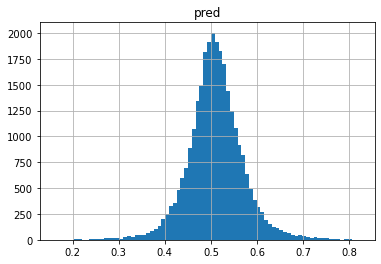

In [19]:
preds = []
if tgt_encode:
    for col in cat_tgtenc_cols:
        print(col)
        X, test_X = prepro.target_encoder(X, test_X, col, y)

    X, test_X = prepro.reskin_tgt_encoding(X, test_X, y)
    X = prepro.add_numeric_info(X, ["mode * reskin"])
    test_X = prepro.add_numeric_info(test_X, ["mode * reskin"])    


        
for i in range(K):
    model = models[i]
    pred = model.predict(test_X)
    preds.append(pred)
    print(np.sum(pred) / pred.shape[0])
    
preds = np.array(preds)
preds = np.mean(preds, axis=0)
print(np.sum(preds) / preds.shape[0])


temp = pd.DataFrame({"pred":pred})
temp.hist(bins=80)

In [20]:
preds_ = np.where(preds < THRESHOLD, 0, 1)
print(np.sum(preds_) / preds_.shape[0])

submit_df = pd.DataFrame({'y': preds_})
submit_df.index.name = 'id'
submit_df.to_csv('../Submissions/submission14_{}.csv'.format(K))

0.5744883556810162


# モデル解釈

In [ ]:
preds

In [ ]:
importance = pd.DataFrame(models[0].feature_importance(), index=train_Xs[0].columns, columns=['importance']).sort_values('importance', ascending=False)
display(importance.iloc[:100])

In [ ]:
indices = [index for index in importance.index if "A1" in index]
importance.loc[indices]

In [ ]:
indices = [index for index in importance.index if "range-sub" in index]
importance.loc[indices]

In [ ]:
importance["importance"].sum()

In [ ]:
train_df["pred"] = 0
train_df["y"] = y
for i in range(K):
    train_df["pred"].iloc[folds[i]] = train_pred[i]
for mode in train_df["mode"].unique():
    rate = train_df[train_df["mode"] == mode][train_df["pred"] == train_df["y"]].shape[0] / train_df[train_df["mode"] == mode].shape[0]
    print("{} : {}".format(mode, rate))
print(train_df[train_df["pred"] == train_df["y"]].shape[0] / train_df.shape[0])

In [ ]:
result_df = train_df[train_df["y"] != train_df["pred"]]

In [ ]:
result_df.to_csv("../../data/result.csv", index=False)

In [ ]:
print(train_df[train_df["mode"] == "nawabari"].shape[0]/train_df.shape[0])
print(train_df[train_df["mode"] == "hoko"].shape[0]/train_df.shape[0])
print(train_df[train_df["mode"] == "asari"].shape[0]/train_df.shape[0])
print(train_df[train_df["mode"] == "area"].shape[0]/train_df.shape[0])
print(train_df[train_df["mode"] == "yagura"].shape[0]/train_df.shape[0])

In [ ]:
print(result_df[result_df["mode"] == "nawabari"].shape[0]/result_df.shape[0])
print(result_df[result_df["mode"] == "hoko"].shape[0]/result_df.shape[0])
print(result_df[result_df["mode"] == "asari"].shape[0]/result_df.shape[0])
print(result_df[result_df["mode"] == "area"].shape[0]/result_df.shape[0])
print(result_df[result_df["mode"] == "yagura"].shape[0]/result_df.shape[0])

In [ ]:
result_df.loc[:100]

In [ ]:
num_cols_ = [
    "range-main", "range-bullet-main", "range-draw-main", "direct_range-sub", "distant-range_sub", 
    "rapid", "atack", "ink-sub", "fav-main", "good-special", "DPS", "kill_time_human-main", "kill_time_ika-main",
    "front_gap_human-main", "front_gap_ika-main", "rensya_frame-main", "saidai_damege-main", "damage_min-sub", 
    "damage_max-sub", "install_num-sub", "good-sub", "direct_range-sub", "damage_max-special", 
    "damage_min-special", "duration-special", "good-special", "direct_rad-special", "close_rad-special", "distant_rad-special"
]


In [ ]:
feature_cols = []
for name in num_cols_:
    for col in X.columns:
        if name in col:
            feature_cols.append(col)
                
importance.loc[feature_cols]#.sort_values('importance', ascending=False)

In [ ]:
sss = []

"""
A-direct_range-sub-mean 30
A-distant_range_sub-max
B-rapid-std	52
ink-sub
A-kill_time_human-main-median	36
A-kill_time_ika-main-median	58
A-front_gap_human-main-std	25
A-front_gap_ika-main-std	48
A-saidai_damege-main-mean	40
damage_max-sub 37
install_num-sub 10
direct_range-sub 30
damage_max-special 47
duration-special 46
close_rad-special 30
distant_rad-special 21
"""




for col in X.columns:
    if "distant_rad-special" in col:
        sss.append(col)
                
importance.loc[sss].sort_values('importance', ascending=False)

In [ ]:
train_df["y"] = y

In [ ]:
reskin_g = pd.concat([
    #train_df[["reskin-A1", "y"]].rename(columns={"reskin-A1" : "reskin"}), 
    train_df[["reskin-A2", "y"]].rename(columns={"reskin-A2" : "reskin"}), 
    train_df[["reskin-A3", "y"]].rename(columns={"reskin-A3" : "reskin"}), 
    train_df[["reskin-A4", "y"]].rename(columns={"reskin-A4" : "reskin"}),
    pd.concat([train_df["reskin-B1"], train_df["y"].apply(lambda x : 1-x)], axis=1).rename(columns={"reskin-B1" : "reskin"}),
    pd.concat([train_df["reskin-B2"], train_df["y"].apply(lambda x : 1-x)], axis=1).rename(columns={"reskin-B2" : "reskin"}),
    pd.concat([train_df["reskin-B3"], train_df["y"].apply(lambda x : 1-x)], axis=1).rename(columns={"reskin-B3" : "reskin"}),
    pd.concat([train_df["reskin-B4"], train_df["y"].apply(lambda x : 1-x)], axis=1).rename(columns={"reskin-B4" : "reskin"}),
],axis=0, ignore_index=True).groupby("reskin")

In [ ]:
win_rate = reskin_g.sum() / reskin_g.count()

In [ ]:
win_rate

In [ ]:
weapon = pd.concat([
    #train_df[["weapon-A1", "y"]].rename(columns={"weapon-A1" : "weapon"}), 
    train_df[["A2-weapon", "y"]].rename(columns={"A2-weapon" : "weapon"}), 
    train_df[["A3-weapon", "y"]].rename(columns={"A3-weapon" : "weapon"}), 
    train_df[["A4-weapon", "y"]].rename(columns={"A4-weapon" : "weapon"}),
    pd.concat([train_df["B1-weapon"], train_df["y"].apply(lambda x : 1-x)], axis=1).rename(columns={"B1-weapon" : "weapon"}),
    pd.concat([train_df["B2-weapon"], train_df["y"].apply(lambda x : 1-x)], axis=1).rename(columns={"B2-weapon" : "weapon"}),
    pd.concat([train_df["B3-weapon"], train_df["y"].apply(lambda x : 1-x)], axis=1).rename(columns={"B3-weapon" : "weapon"}),
    pd.concat([train_df["B4-weapon"], train_df["y"].apply(lambda x : 1-x)], axis=1).rename(columns={"B4-weapon" : "weapon"}),
],axis=0, ignore_index=True)

In [ ]:
win_rate = (weapon.groupby("weapon").sum() / weapon.groupby("weapon").count()).sort_values("y", ascending=False)
win_rate.loc["bold_7"]

In [ ]:
def mizumashi_perm(df, y):
    df["y"] = y
    li = ["B1", "B2", "B3", "B4"]
    cols = df.columns
    for p1, p2, p3, p4 in itertools.permutations(li):
        B1_cols = [col for col in cols if "B1" in col]
        B2_cols = [col for col in cols if "B1" in col]
        B3_cols = [col for col in cols if "B1" in col]
        B4_cols = [col for col in cols if "B1" in col]
    
    
    
    y = df["y"].values
    df.drop(columns=["y"], inplace=True)
    return df, y

In [ ]:
train_df

In [ ]:
li = [[1, 2, 3], [2, 3, 4]]

In [ ]:
print(*li)